In [1]:
                          #import knižníc
import tensorflow as tf                          #predikcia
import numpy as np                               #nasobenie matic
import pandas as pd                              #definovanie datových štruktur
import matplotlib.pyplot as plt                  #vizualizácia
from sklearn.preprocessing import StandardScaler #normalizácia dát
%matplotlib inline

In [2]:
#nacítanie suboru
btc = pd.read_csv('btc3.csv')
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,2019-05-07,BTCUSD,5687.90,5966.37,5687.90,5907.47,6179.72,3.622665e+07
1,2019-05-06,BTCUSD,5715.86,5753.66,5564.93,5687.90,8983.11,5.084587e+07
2,2019-05-05,BTCUSD,5770.01,5782.22,5627.35,5715.86,5700.46,3.258224e+07
3,2019-05-04,BTCUSD,5657.40,5846.88,5512.00,5770.01,10457.85,5.957420e+07
4,2019-05-03,BTCUSD,5390.01,5796.93,5363.00,5657.40,19076.57,1.077853e+08


In [3]:
#zvolenie stplca ktory sa bude použivat
data_to_use=btc['Close'].values
data_to_use

array([5907.47, 5687.9 , 5715.86, ...,  378.  ,  378.  ,  370.  ])

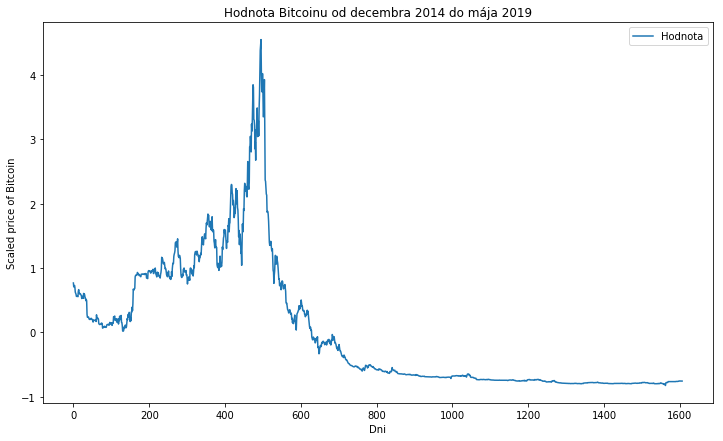

In [4]:
#predspracovanie údajov (škálovanie)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

#vykreslenie dát 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Hodnota Bitcoinu od decembra 2014 do mája 2019')
plt.xlabel('Dni')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Hodnota')
plt.legend()
plt.show()

In [5]:
#funkcia na vytvorenie vlastnosti a popisu datasetu pre vyzualizáciu dát

#Input: data - dátový súbor použitý v projekte
#window_size - koľko dátových bodov sa bude používať na predpovedanie ďalšieho údajového bodu v sekvencii
#[príklad: ak window_size = 1 použije sa len predchádzajúci deň na predpovedanie dnešnej hodnoty]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', čislo v sekvenci ktoré sa snažime predpovedat

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#zobrazenie dát pomocou funkcie window_data
X, y = window_data(scaled_data, 7)

#Trenovacia a testovacia mnozina udajov
#rozdelenie dat na testovacie a trenovacie
import numpy as np
X_train  = np.array(X[:1339])
y_train = np.array(y[:1339])

X_test = np.array(X[1339:])
y_test = np.array(y[1339:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1339, 7, 1)
y_train size: (1339, 1)
X_test size: (261, 7, 1)
y_test size: (261, 1)


In [6]:
#Definovanie siete
#Hyperparamtere vysvetľujú vyššie štrukturálne informácie o modeli.

batch_size = 7  #koľko okien údajov naraz prejde
window_size = 7 #ako veľký je window_size (alebo pomocou kolkých dní chceme predikovať další bod v sekvencii)
hidden_layer = 256 #Hkoľko jednotiek používame v bunke LSTM
clip_margin = 4 #Aby sme predišli explozívnemu gradientu, používame clipper na spúšťanie gradientov pod okrajom alebo nad týmto okrajom
learning_rate = 0.001 
epochs = 200 

import tensorflow as tf
#definácia placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

#váhy a implementácia neuronu 
# LSTM vahy

#Výhy pre input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#Výhy pre forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#Výhy pre the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#Výhy pre the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer váhy
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#funkcia pre vypočet stavov brany
def LSTM_cell(input, output, state):
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 #Definícia cyklu pre sieť
outputs = []
for i in range(batch_size): #iteruje ccez každe window v každej dávke
  
    #pre každu davku sa vytvara bach_state s nulami a vystup pre toto okno obsahuje rovnako nuly
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #pre kazdy bod plati ze ho pridavame do LSTM pre ziskanie dalšieho vystupu
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    
    #posledny vystup sa použiva na ziskanie predikcie
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>]

In [7]:
#definovanie straty
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#definujeme optimalizátor s gradientovým orezaním
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#trenovanie siete
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
        

Epoch 0/200  Current loss: 0.16169071197509766
Epoch 30/200  Current loss: 0.24259091913700104
Epoch 60/200  Current loss: 0.009742147289216518
Epoch 90/200  Current loss: 0.011805953457951546
Epoch 120/200  Current loss: 0.00899423100054264
Epoch 150/200  Current loss: 0.007708457764238119
Epoch 180/200  Current loss: 0.0062539242208004


In [8]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [9]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [10]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])
        

In [11]:
test_results = []
for i in range(1585): 
    if i >= 1340: 
        test_results.append(tests_new[i-1340])
    else:
        test_results.append(None)

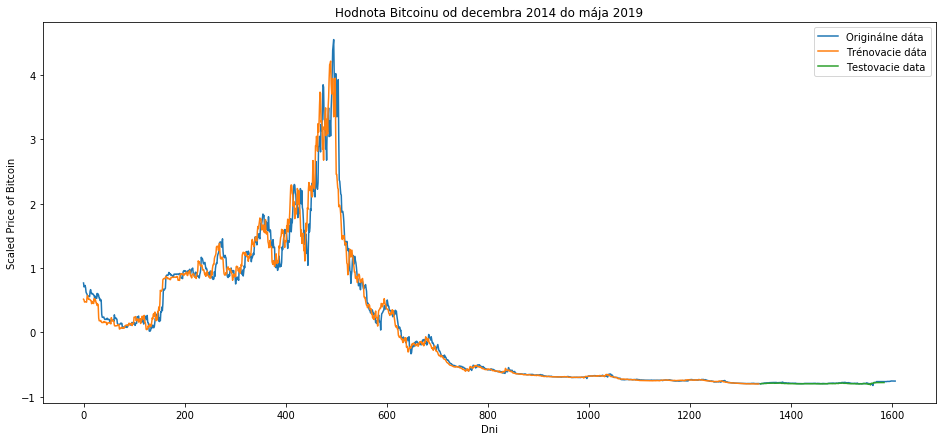

In [13]:
#vykreslenie predikcie z neuronovej siete

plt.figure(figsize=(16, 7))
plt.title('Hodnota Bitcoinu od decembra 2014 do mája 2019')
plt.xlabel('Dni')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Originálne dáta')
plt.plot(sup, label='Trénovacie dáta')
plt.plot(test_results, label='Testovacie data')
plt.legend()
plt.show()